In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
# from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler

In [3]:
#load_dataset
with open("./zhengqi_train.txt")  as fr:
    data_train=pd.read_table(fr,sep="\t")
with open("./zhengqi_test.txt") as fr_test:
    data_test=pd.read_table(fr_test,sep="\t")

In [4]:
data_train["oringin"]="train"
data_test["oringin"]="test"
data_all=pd.concat([data_train,data_test],axis=0,ignore_index=True)

In [5]:
data_all.drop(["V5","V9","V11","V17","V22","V28"],axis=1,inplace=True)

In [6]:
# normalise numeric columns
cols_numeric=list(data_all.columns)
cols_numeric.remove("oringin")
def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
scale_cols = [col for col in cols_numeric if col!='target']
data_all[scale_cols] = data_all[scale_cols].apply(scale_minmax,axis=0)

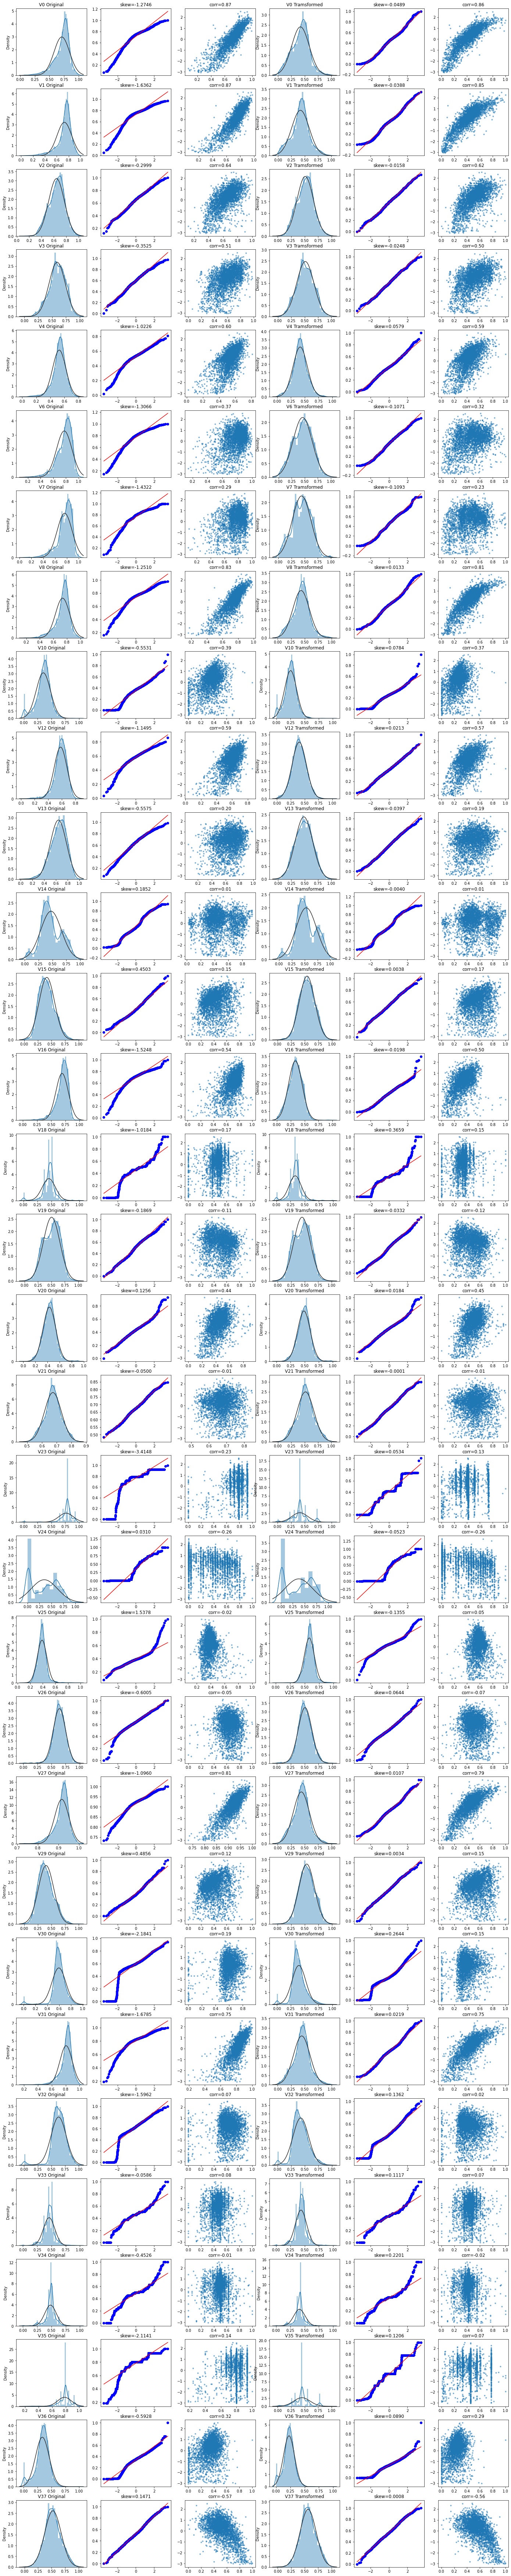

In [7]:
#Check effect of Box-Cox transforms on distributions of continuous variables

fcols = 6
frows = len(cols_numeric)-1
plt.figure(figsize=(4*fcols,4*frows))
i=0

for var in cols_numeric:
    if var!='target':
        dat = data_all[[var, 'target']].dropna()
        
        i+=1
        plt.subplot(frows,fcols,i)
        sns.distplot(dat[var] , fit=stats.norm);
        plt.title(var+' Original')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(dat[var], dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
 
        i+=1
        plt.subplot(frows,fcols,i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)      
        sns.distplot(trans_var , fit=stats.norm);
        plt.title(var+' Tramsformed')
        plt.xlabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        _=stats.probplot(trans_var, plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(trans_var)))
        plt.xlabel('')
        plt.ylabel('')
        
        i+=1
        plt.subplot(frows,fcols,i)
        plt.plot(trans_var, dat['target'],'.',alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(trans_var,dat['target'])[0][1]))

In [8]:
cols_transform=data_all.columns[0:-2]
for col in cols_transform:   
    # transform column
    data_all.loc[:,col], _ = stats.boxcox(data_all.loc[:,col]+1)

count    2888.000000
mean        0.126353
std         0.983966
min        -3.044000
25%        -0.350250
50%         0.313000
75%         0.793250
max         2.538000
Name: target, dtype: float64


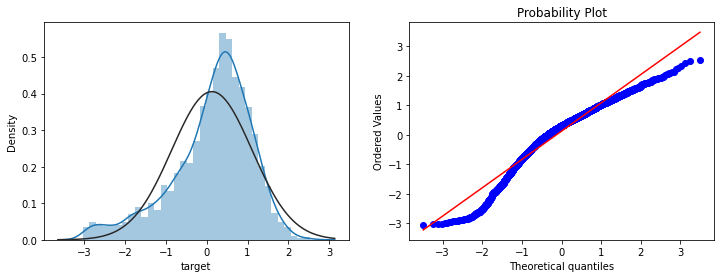

In [9]:
print(data_all.target.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_all.target.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_all.target.dropna(), plot=plt)

count    2888.000000
mean        1.129957
std         0.394110
min         0.291057
25%         0.867609
50%         1.135315
75%         1.379382
max         2.798463
Name: target, dtype: float64


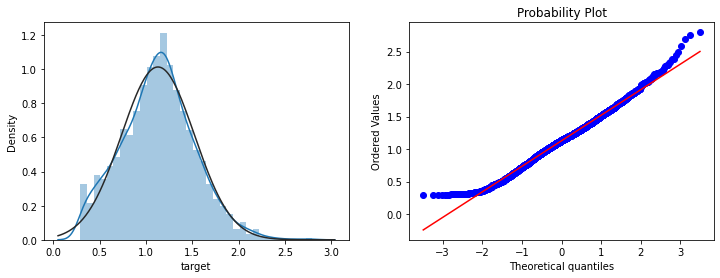

In [10]:
#Log Transform SalePrice to improve normality
sp = data_train.target
data_train.target1 =np.power(1.5,sp)
print(data_train.target1.describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(data_train.target1.dropna(),fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(data_train.target1.dropna(), plot=plt)

In [11]:
# function to get training samples
def get_training_data():
    # extract training samples
    from sklearn.model_selection import train_test_split
    df_train = data_all[data_all["oringin"]=="train"]
    df_train["label"]=data_train.target1
    # split SalePrice and features
    y = df_train.target
    X = df_train.drop(["oringin","target","label"],axis=1)
    X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.3,random_state=100)
    return X_train,X_valid,y_train,y_valid

# extract test data (without SalePrice)
def get_test_data():
    df_test = data_all[data_all["oringin"]=="test"].reset_index(drop=True)
    return df_test.drop(["oringin","target"],axis=1)

In [12]:
from sklearn.metrics import make_scorer
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)
def mse(y_ture,y_pred):
    return mean_squared_error(y_ture,y_pred)

# scorer to be used in sklearn model fitting
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mse_scorer = make_scorer(mse, greater_is_better=False)

In [13]:
# function to detect outliers based on the predictions of a model
def find_outliers(model, X, y, sigma=3):

    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X,y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    outliers = z[abs(z)>sigma].index
    
    # print and plot the results
    print('R2=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print("mse=",mean_squared_error(y,y_pred))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())

    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.loc[outliers],y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(y.loc[outliers],y.loc[outliers]-y_pred.loc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    z.loc[outliers].plot.hist(color='r',bins=50,ax=ax_133)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z')
    
    plt.savefig('outliers.png')
    
    return outliers

R2= 0.8794138470398789
rmse= 0.345103388229878
mse= 0.11909634856774177
---------------------------------------
mean of residuals: -4.340911598509642e-16
std of residuals: 0.3451887992912601
---------------------------------------
23 outliers:
[2655, 2159, 1164, 2863, 1145, 2697, 2528, 2645, 691, 1085, 1874, 2647, 776, 2625, 884, 2696, 2668, 1310, 1901, 2769, 2002, 2669, 1040]


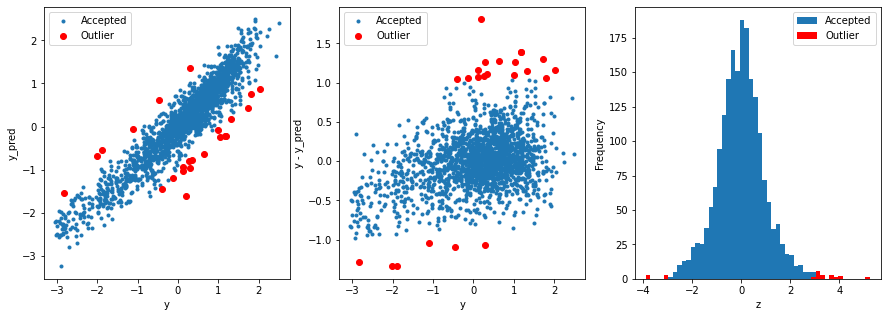

In [14]:
# get training data
from sklearn.linear_model import Ridge
X_train, X_valid,y_train,y_valid = get_training_data()
test=get_test_data()

# find and remove outliers using a Ridge model
outliers = find_outliers(Ridge(), X_train, y_train)

# permanently remove these outliers from the data
#df_train = data_all[data_all["oringin"]=="train"]
#df_train["label"]=data_train.target1
#df_train=df_train.drop(outliers)
X_outliers=X_train.loc[outliers]
y_outliers=y_train.loc[outliers]
X_t=X_train.drop(outliers)
y_t=y_train.drop(outliers)

In [15]:
def get_trainning_data_omitoutliers():
    y1=y_t.copy()
    X1=X_t.copy()
    return X1,y1

In [16]:

from sklearn.preprocessing import StandardScaler
def train_model(model, param_grid=[], X=[], y=[], 
                splits=5, repeats=5):

    # get unmodified training data, unless data to use already specified
    if len(y)==0:
        X,y = get_trainning_data_omitoutliers()
        #poly_trans=PolynomialFeatures(degree=2)
        #X=poly_trans.fit_transform(X)
        #X=MinMaxScaler().fit_transform(X)
    
    # create cross-validation method
    rkfold = RepeatedKFold(n_splits=splits, n_repeats=repeats)
    
    # perform a grid search if param_grid given
    if len(param_grid)>0:
        # setup grid search parameters
        gsearch = GridSearchCV(model, param_grid, cv=rkfold,
                               scoring="neg_mean_squared_error",
                               verbose=1, return_train_score=True)

        # search the grid
        gsearch.fit(X,y)

        # extract best model from the grid
        model = gsearch.best_estimator_        
        best_idx = gsearch.best_index_

        # get cv-scores for best model
        grid_results = pd.DataFrame(gsearch.cv_results_)       
        cv_mean = abs(grid_results.loc[best_idx,'mean_test_score'])
        cv_std = grid_results.loc[best_idx,'std_test_score']

    # no grid search, just cross-val score for given model    
    else:
        grid_results = []
        cv_results = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=rkfold)
        cv_mean = abs(np.mean(cv_results))
        cv_std = np.std(cv_results)
    
    # combine mean and std cv-score in to a pandas series
    cv_score = pd.Series({'mean':cv_mean,'std':cv_std})

    # predict y using the fitted model
    y_pred = model.predict(X)
    
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('score=',model.score(X,y))
    print('rmse=',rmse(y, y_pred))
    print('mse=',mse(y, y_pred))
    print('cross_val: mean=',cv_mean,', std=',cv_std)
    
    # residual plots
    y_pred = pd.Series(y_pred,index=y.index)
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    z = (resid - mean_resid)/std_resid    
    n_outliers = sum(abs(z)>3)
    
    plt.figure(figsize=(15,5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y,y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y_pred');
    plt.title('corr = {:.3f}'.format(np.corrcoef(y,y_pred)[0][1]))
    ax_132=plt.subplot(1,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.xlabel('y')
    plt.ylabel('y - y_pred');
    plt.title('std resid = {:.3f}'.format(std_resid))
    
    ax_133=plt.subplot(1,3,3)
    z.plot.hist(bins=50,ax=ax_133)
    plt.xlabel('z')
    plt.title('{:.0f} samples with z>3'.format(n_outliers))

    return model, cv_score, grid_results

In [17]:
# places to store optimal models and scores
opt_models = dict()
score_models = pd.DataFrame(columns=['mean','std'])

# no. k-fold splits
splits=5
# no. k-fold iterations
repeats=5

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Ridge(alpha=0.25)
----------------------
score= 0.8963563382503371
rmse= 0.31899649199238556
mse= 0.101758761903448
cross_val: mean= 0.10638131747212537 , std= 0.007569180416828834


Text(0, 0.5, 'score')

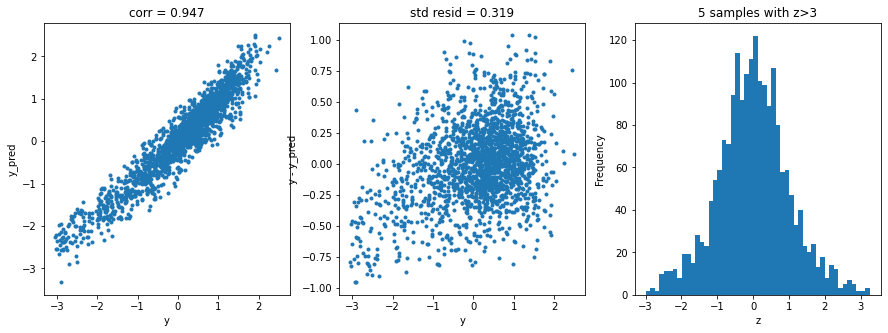

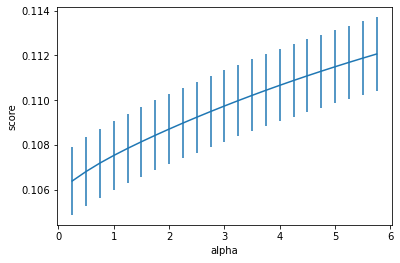

In [18]:
model = 'Ridge'

opt_models[model] = Ridge()
alph_range = np.arange(0.25,6,0.25)
param_grid = {'alpha': alph_range}

opt_models[model],cv_score,grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),
             abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

Fitting 25 folds for each of 23 candidates, totalling 575 fits
----------------------
Lasso(alpha=0.0001)
----------------------
score= 0.8965376025070487
rmse= 0.3187174205810588
mse= 0.10158079418184365
cross_val: mean= 0.10648223018464748 , std= 0.006071816944716394


Text(0, 0.5, 'score')

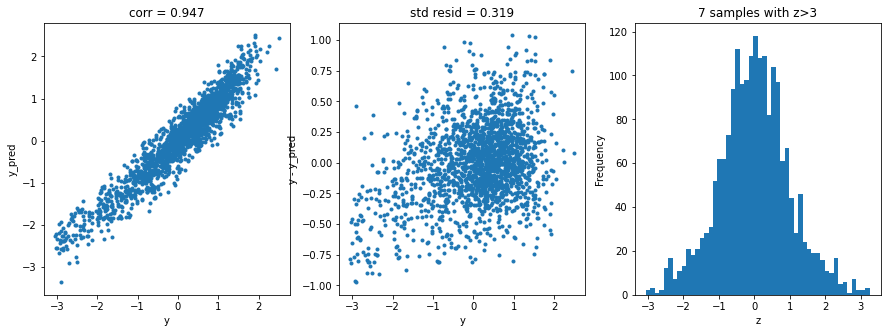

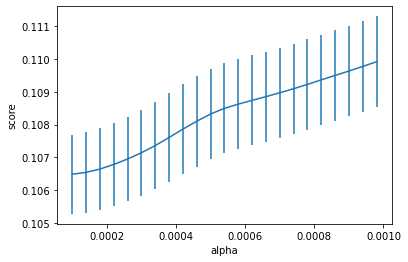

In [19]:
model = 'Lasso'

opt_models[model] = Lasso()
alph_range = np.arange(1e-4,1e-3,4e-5)
param_grid = {'alpha': alph_range}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(alph_range, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('alpha')
plt.ylabel('score')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------------------
ElasticNet(alpha=0.0001, l1_ratio=0.9, max_iter=100000)
----------------------
score= 0.8965268229145461
rmse= 0.31873402349437113
mse= 0.1015913777329105
cross_val: mean= 0.10639405152426343 , std= 0.002890000999813687


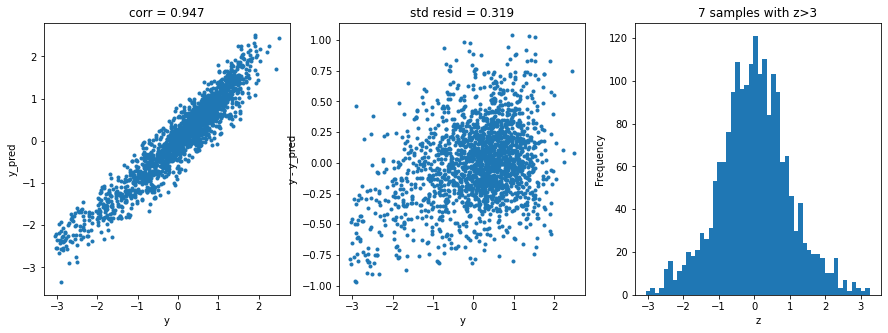

In [20]:
model ='ElasticNet'
opt_models[model] = ElasticNet()

param_grid = {'alpha': np.arange(1e-4,1e-3,1e-4),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

Fitting 25 folds for each of 9 candidates, totalling 225 fits
----------------------
LinearSVR(C=0.1)
----------------------
score= -12.826023727240244
rmse= 3.6843695293566765
mse= 13.574578828851914
cross_val: mean= 0.7950130374080286 , std= 0.25085929883026453


Text(0, 0.5, 'score')

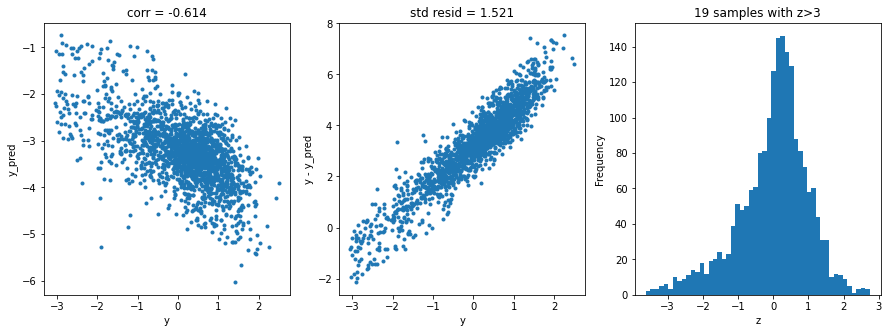

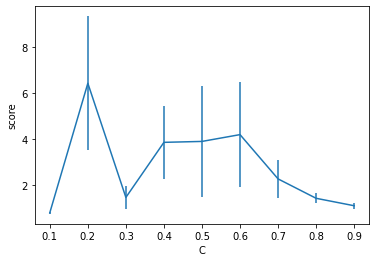

In [21]:
model='LinearSVR'
opt_models[model] = LinearSVR()

crange = np.arange(0.1,1.0,0.1)
param_grid = {'C':crange,
             'max_iter':[1000]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=repeats)


cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(crange, abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*repeats))
plt.xlabel('C')
plt.ylabel('score')



Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------------------
KNeighborsRegressor(n_neighbors=10)
----------------------
score= 0.7188007679386812
rmse= 0.5254381453364182
mse= 0.27608524457457456
cross_val: mean= 0.34519267064793235 , std= 0.017623421403182425


Text(0, 0.5, 'score')

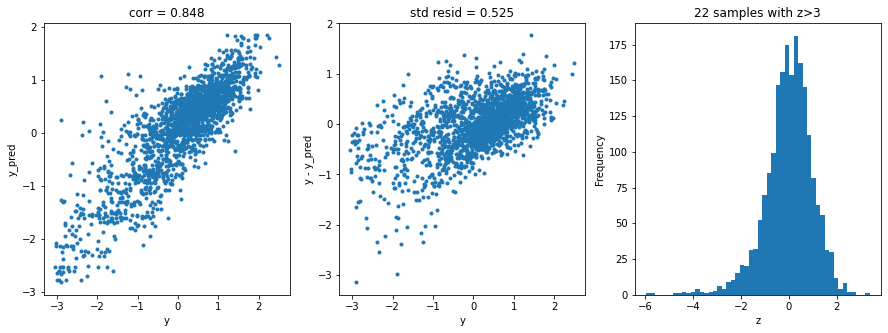

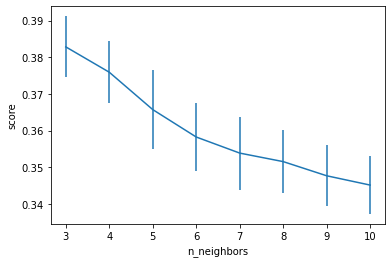

In [22]:
model = 'KNeighbors'
opt_models[model] = KNeighborsRegressor()

param_grid = {'n_neighbors':np.arange(3,11,1)}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=splits, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

plt.figure()
plt.errorbar(np.arange(3,11,1), abs(grid_results['mean_test_score']),abs(grid_results['std_test_score'])/np.sqrt(splits*1))
plt.xlabel('n_neighbors')
plt.ylabel('score')

Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------------------
RandomForestRegressor(max_features=16, n_estimators=200)
----------------------
score= 0.9857074916961173
rmse= 0.1184591902470699
mse= 0.014032579753991496
cross_val: mean= 0.102963065288272 , std= 0.0014474544846284918


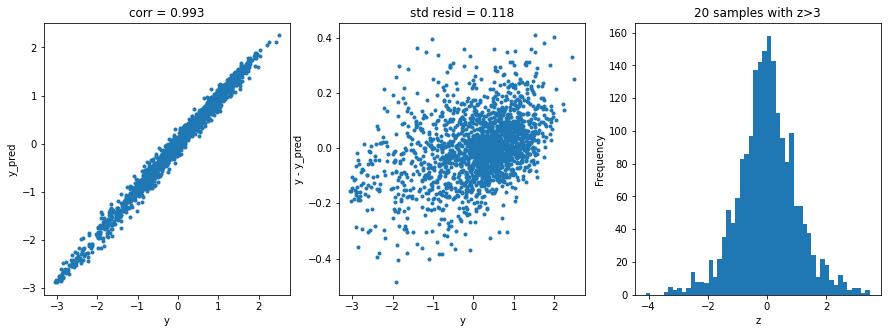

In [23]:
model = 'RandomForest'
opt_models[model] = RandomForestRegressor()

param_grid = {'n_estimators':[100,150,200],
              'max_features':[8,12,16,20,24],
              'min_samples_split':[2,4,6]}

opt_models[model], cv_score, grid_results = train_model(opt_models[model], param_grid=param_grid, 
                                              splits=5, repeats=1)

cv_score.name = model
score_models = score_models.append(cv_score)

In [24]:
def model_predict(test_data,test_y=[],stack=False):
    #poly_trans=PolynomialFeatures(degree=2)
    #test_data1=poly_trans.fit_transform(test_data)
    #test_data=MinMaxScaler().fit_transform(test_data)
    i=0
    y_predict_total=np.zeros((test_data.shape[0],))
    for model in opt_models.keys():
        if model!="LinearSVR" and model!="KNeighbors":
            y_predict=opt_models[model].predict(test_data)
            y_predict_total+=y_predict
            i+=1
        if len(test_y)>0:
            print("{}_mse:".format(model),mean_squared_error(y_predict,test_y))
    y_predict_mean=np.round(y_predict_total/i,3)
    if len(test_y)>0:
        print("mean_mse:",mean_squared_error(y_predict_mean,test_y))
    else:
        y_predict_mean=pd.Series(y_predict_mean)
        return y_predict_mean

In [25]:
model_predict(X_valid,y_valid)

Ridge_mse: 0.13767187882302995
Lasso_mse: 0.13786142853928038
ElasticNet_mse: 0.13782685546163495
LinearSVR_mse: 0.13782685546163495
KNeighbors_mse: 0.13782685546163495
RandomForest_mse: 0.1382267787640427
mean_mse: 0.13021861361014994
